<h1><center>Q9. Image classification with neural networks</center></h1>

<b>In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

- overall test-set accuracy, measured however you think is appropriate
- show some of the example images from the test set, together with your model's predicted classes.
- a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).

I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably. </b>

## Solution:

<b>Table of Contents</b>

- Check for CUDA compatibility
- Architecture
- Data Processing 
    - Network 1 (Test Set Accuracy: 80.92%)
    - Network 2 (Test Set Accuracy: 81.91%)
    - Resnet18 (Test Set Accuracy: 88.78%) <- Please consider this network for evaluation as the previous ones act as a walkthrough to ResNet18.
- Solutions to questions:
    - Overall test-set accuracy, measured however you think is appropriate
    - Show some of the example images from the test set, together with your model's predicted classes
    - Confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class)
- Summary
- Model Performance 

Check for CUDA compatibility

In [1]:
import torch

In [2]:
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [3]:
torch.cuda.device_count()

1

In [4]:
torch.version.cuda

'11.7'

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<b>Architecture:</b>

The LeNet architecture, one of the pioneering Convolutional Neural Network (CNN) models, was chosen as a foundational architecture for this task. Its simplicity and effectiveness in recognizing visual patterns made it an attractive starting point for the image classification problem at hand.

LeNet was chose as Inspiration because:
- Proven Success in Image Recognition: LeNet's success in digit recognition tasks demonstrated its capability to extract hierarchical features from images.
- Simplicity and Efficiency: LeNet's relatively simple structure provides a clear blueprint for understanding and building CNNs.
- Modularity: LeNet's modular design allows for easy adaptation and modification.

##### Deviations from LeNet:
Input Channels:
- LeNet: Single-channel grayscale images.
-   Custom Model: 3-channel RGB images.
-  Justification: Color images contain richer information.

Filter Size:
-  LeNet: 5x5 convolutional filters.
-  Custom Model: 3x3 filters.
-  Justification: Reduced filter size aligns with modern practices - increased non-linearity, computational efficiency, empirical success (VGG + ResNet) and to prevent overfitting.

Pooling Method:
-   LeNet: Average pooling.
-   Custom Model: Max pooling.
-   Justification: Max pooling emphasizes prominent features.

Fully Connected Layers:
-   LeNet: Multiple fully connected layers.
-   Custom Model: Fewer fully connected layers.
-   Justification: Reduction in complexity helps mitigate overfitting.

Number of Classes:
-   LeNet: 10 classes for digit recognition.
-   Custom Model: 11 classes tailored to the specific task.
-   Justification: The custom model was designed to match the specific classification task.

<b>Data Processing</b>

In [15]:
# Step 2: Load Dataset
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = ImageFolder(root='STA380/STA380-master/data/EuroSAT_RGB', transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Network 1

In [17]:
# Step 3: Define the CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 11) # 11 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [18]:
# Step 4: Train the Model
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for epoch in range(10): # 10 epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

Test Set Accuracy - Network 1

In [19]:
# Step 5: Evaluate the Model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())

accuracy = correct / total
print(f'Overall Test-Set Accuracy: {accuracy * 100}%')

Overall Test-Set Accuracy: 80.92592592592592%


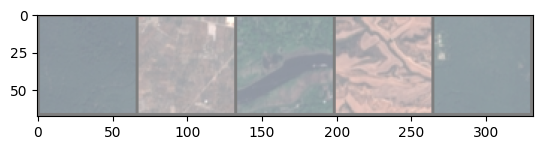

Predicted:  Forest  PermanentCrop  River  PermanentCrop  Forest 
Actual:     Forest  PermanentCrop  River  HerbaceousVegetation  Forest 


In [45]:
import random
classes = dataset.classes

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Move the image to CPU and unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Move the model to the GPU (if using CUDA)
model = model.cuda()

# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# Move the images to the GPU (if using CUDA)
images = images.cuda()

# Pass the images through the model
outputs = model(images)

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Move the images to the CPU for displaying
images_cpu = images.cpu()

num_images_to_display = 5
random_indices = random.sample(range(len(images_cpu)), num_images_to_display)

# Select random images and corresponding labels
random_images = images_cpu[random_indices]
random_predicted_labels = predicted[random_indices]
random_actual_labels = labels[random_indices]

# Show the randomly selected images
imshow(torchvision.utils.make_grid(random_images))

# Print the predicted classes for the first 4 images
print('Predicted: ', ' '.join('%5s ' % classes[random_predicted_labels[j]] for j in range(num_images_to_display)))

# Print the actual classes for the first 5 images
print('Actual:    ', ' '.join('%5s ' % classes[random_actual_labels[j]] for j in range(num_images_to_display)))

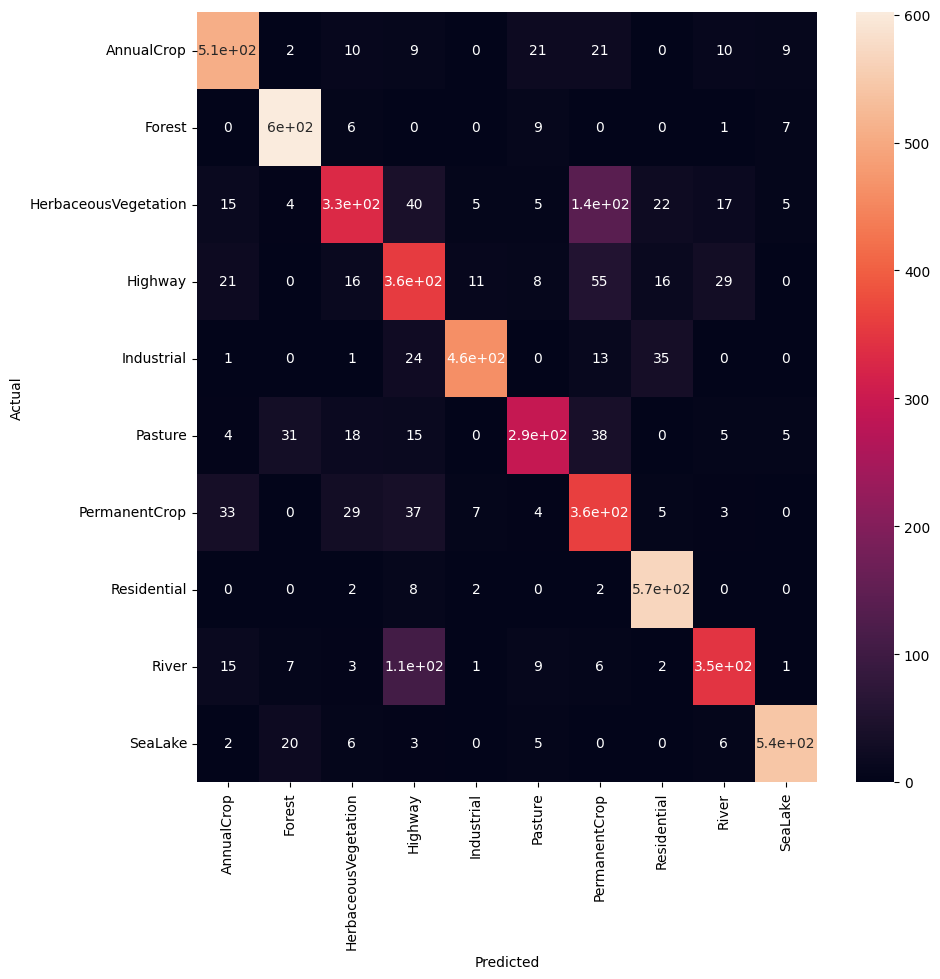

In [22]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<b>Observation:</b> The network confuses highway with river and herbaceous vegetation with permanent crop. 

<b>Adding some more layers to the network to enable the network to capture more details. </b>

In [ ]:
# Step 2: Load Dataset
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root='STA380/STA380-master/data/EuroSAT_RGB', transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Network - 2

In [46]:
# Step 3: Define the CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 11) # 11 classes
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [47]:
# Step 4: Train the Model
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for epoch in range(10): # 10 epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

In [48]:
# Step 5: Evaluate the Model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())

accuracy = correct / total
print(f'Overall Test-Set Accuracy: {accuracy * 100}%')

Overall Test-Set Accuracy: 81.9074074074074%


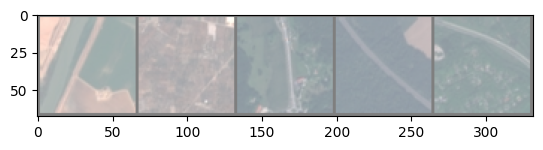

Predicted:  AnnualCrop  PermanentCrop  Highway  Highway  Highway 
Actual:     River  PermanentCrop  Highway  Highway  Highway 


In [50]:
classes = dataset.classes

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Move the image to CPU and unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Move the model to the GPU (if using CUDA)
model = model.cuda()

# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# Move the images to the GPU (if using CUDA)
images = images.cuda()

# Pass the images through the model
outputs = model(images)

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Move the images to the CPU for displaying
images_cpu = images.cpu()

num_images_to_display = 5
random_indices = random.sample(range(len(images_cpu)), num_images_to_display)

# Select random images and corresponding labels
random_images = images_cpu[random_indices]
random_predicted_labels = predicted[random_indices]
random_actual_labels = labels[random_indices]

# Show the randomly selected images
imshow(torchvision.utils.make_grid(random_images))

# Print the predicted classes for the first 4 images
print('Predicted: ', ' '.join('%5s ' % classes[random_predicted_labels[j]] for j in range(num_images_to_display)))

# Print the actual classes for the first 5 images
print('Actual:    ', ' '.join('%5s ' % classes[random_actual_labels[j]] for j in range(num_images_to_display)))

#### ResNet18

In [5]:
# Step 2: Load Dataset
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root='STA380/STA380-master/data/EuroSAT_RGB', transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
from torchvision import models

In [7]:
# Step 3: Define the CNN Model (ResNet-18)
model = models.resnet18(weights = None)
model.fc = nn.Linear(model.fc.in_features, 11) # 11 classes
# Move the model to the GPU (if using CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
# Step 4: Train the Model

num_epochs = 20

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for epoch in range(num_epochs): # 20 epochs
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99: # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Mini-batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0


Epoch 1, Mini-batch 100, Loss: 1.373726725578308
Epoch 1, Mini-batch 200, Loss: 1.0918303632736206
Epoch 1, Mini-batch 300, Loss: 0.9530681675672531
Epoch 2, Mini-batch 100, Loss: 0.8960142064094544
Epoch 2, Mini-batch 200, Loss: 0.8762201434373855
Epoch 2, Mini-batch 300, Loss: 0.8132086664438247
Epoch 3, Mini-batch 100, Loss: 0.75115194439888
Epoch 3, Mini-batch 200, Loss: 0.7310359394550323
Epoch 3, Mini-batch 300, Loss: 0.6791975322365761
Epoch 4, Mini-batch 100, Loss: 0.6863639816641808
Epoch 4, Mini-batch 200, Loss: 0.6472729679942131
Epoch 4, Mini-batch 300, Loss: 0.62037563174963
Epoch 5, Mini-batch 100, Loss: 0.6056632214784622
Epoch 5, Mini-batch 200, Loss: 0.5643149477243423
Epoch 5, Mini-batch 300, Loss: 0.5689493206143379
Epoch 6, Mini-batch 100, Loss: 0.5268041458725929
Epoch 6, Mini-batch 200, Loss: 0.5338302376866341
Epoch 6, Mini-batch 300, Loss: 0.5326879632472992
Epoch 7, Mini-batch 100, Loss: 0.49968351915478704
Epoch 7, Mini-batch 200, Loss: 0.46253909945487975
Epo

<b>Question: Overall test-set accuracy</b>

In [9]:
# Step 5: Evaluate the Model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu())
        all_labels.extend(labels.cpu())

accuracy = correct / total
print(f'Overall Test-Set Accuracy: {accuracy * 100}%')

Overall Test-Set Accuracy: 88.77777777777777%


In [11]:
import random

<b>Question: Show some of the example images from the test set, together with your model's predicted classes.</b>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


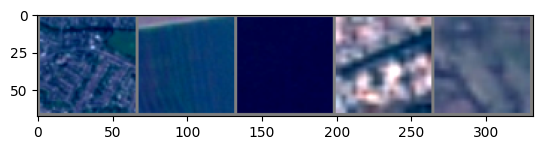

Predicted:  Residential  AnnualCrop  SeaLake  HerbaceousVegetation  HerbaceousVegetation 
Actual:     Residential  AnnualCrop  SeaLake  Residential  HerbaceousVegetation 


In [13]:
classes = dataset.classes

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Move the image to CPU and unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# Move the images to the GPU (if using CUDA)
images = images.cuda()

# Pass the images through the model
outputs = model(images)

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Move the images to the CPU for displaying
images_cpu = images.cpu()

num_images_to_display = 5
random_indices = random.sample(range(len(images_cpu)), num_images_to_display)

# Select random images and corresponding labels
random_images = images_cpu[random_indices]
random_predicted_labels = predicted[random_indices]
random_actual_labels = labels[random_indices]

# Show the randomly selected images
imshow(torchvision.utils.make_grid(random_images))

# Print the predicted classes for the first 4 images
print('Predicted: ', ' '.join('%5s ' % classes[random_predicted_labels[j]] for j in range(num_images_to_display)))

# Print the actual classes for the first 5 images
print('Actual:    ', ' '.join('%5s ' % classes[random_actual_labels[j]] for j in range(num_images_to_display)))

<b>Question: Confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).</b>

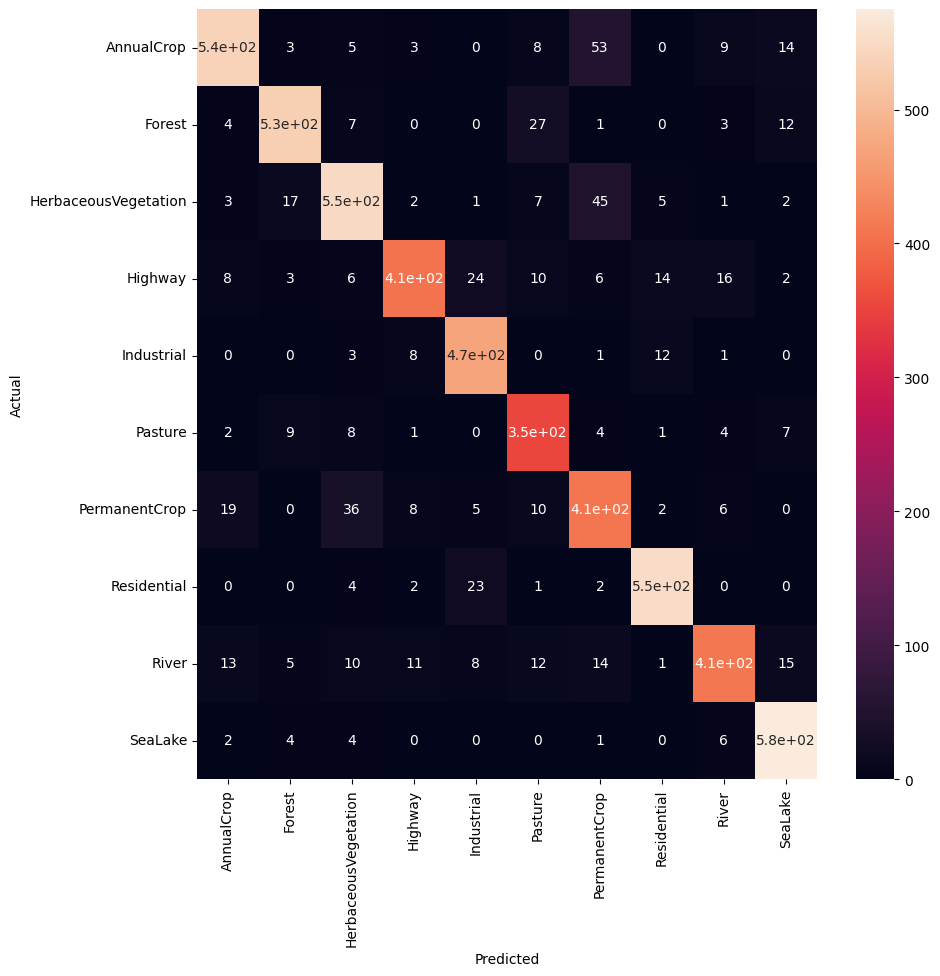

In [14]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<b>Summary:</b>

Layers: ResNet-18 is composed of 5 main layers:

- Convolutional Layer: Initial layer with 7x7 filters, followed by max pooling.
- Convolutional Blocks: Four convolutional blocks, each containing two residual blocks with 3x3 filters. The number of filters doubles with each subsequent block, starting with 64 filters.
- Batch Normalization: Each convolutional layer is typically followed by batch normalization.
- Activation Function: ReLU (Rectified Linear Unit) activation functions are used throughout the network.

Global Average Pooling: After the convolutional layers, global average pooling is applied, reducing the spatial dimensions.

Fully Connected Layer: The code customizes the final fully connected layer to have 11 output classes. This layer is responsible for the final classification, mapping the high-level features learned by the network into probability scores for each class.

<b>Model Performance:</b>

Compared with Network - 1, ResNet 18 is able to capture the difficulty in predicting properly between highway and river. 
But it still struggles a bit with Herbaceous vegetation and Permanent Crop but the improvement has been from 170 misclassified images to just 81.
However, we see that ResNet has some difficulty with properly classifying annual crop and herbaceous vegetation, relatively. 